In [364]:
import json
import os
import pandas as pd
import numpy as np
import re
import missingno as msno

In [365]:
# Input and output directories
input_directory = './Jsons'
output_file = './mobile_data.csv'

# Define the column headers for the output CSV
columns = [
    "name", "brand", "2G", "3G", "4G", "5G", "Announced", "Status", "Weight", "Length", "Width", 
    "Diameter", "SIM", "Display Type", "Display Size", "PPI", "Body Ratio", "OS", "Battery_capacity", 
    "Price", "CPU", "Ratio", "Pixel", "WLAN", "Colors", "Sensors", "Bluetooth", "GPU", 
    "LoudSpeaker", "3.5mm jack", "Chipset", "Network", "Internal", "Card slot", "RAM", "Storage"
]

data = []

def extract_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = json.load(file)
        
        for top_key, models in content.items():
            brand_name = ''.join(filter(str.isalpha, top_key))
            
            for model, specs in models.items():                     # Extract various specifications
                dimensions = specs.get("Body", [{}])[0].get("Dimensions", "")
                dimensions_split = dimensions.split(' x ') if dimensions else []

                price = next((item.get("Price", "") for item in specs.get("Misc", []) if "Price" in item), "")

                chipset = next((item.get("Chipset", "") for item in specs.get("Platform", []) if "Chipset" in item), "")
                cpu = next((item.get("CPU", "") for item in specs.get("Platform", []) if "CPU" in item), "")
                gpu = next((item.get("GPU", "") for item in specs.get("Platform", []) if "GPU" in item), "")
                gpu_from_cpu = re.search(r',\s*(.*GPU)', cpu)
                if gpu_from_cpu:
                    gpu_info = gpu_from_cpu.group(1).rsplit(' GPU', 1)[0]
                    if not gpu:
                        gpu = gpu_info
                    cpu = re.sub(r',\s*.*GPU', '', cpu)

                cpu = re.sub(r'\s*\(.*\)', '', cpu)
                cpu = re.sub(r'(\d+(?:\.\d+)?)\s*GHz', r'\1 GHz', cpu)
                cpu = re.sub(r'(\d+(?:\.\d+)?)\s*MHz', r'\1 MHz', cpu)

                loudspeaker = specs.get("Sound", [{}])[0].get("Loudspeaker", "") == "Yes" if len(specs.get("Sound", [])) > 0 else False
                jack_3_5mm = specs.get("Sound", [{}])[1].get("3.5mm jack", "") == "Yes" if len(specs.get("Sound", [])) > 1 else False

                ram = next((item.get("Internal", "") for item in specs.get("Memory", []) if "RAM" in item.get("Internal", "")), "")
                storage = next((item.get("Internal", "") for item in specs.get("Memory", []) if "Internal" in item), "")
                memory = specs.get("Memory", [{}])
                internal_memory = next((item.get("Internal", "") for item in memory if "Internal" in item), "")
                card_slot = memory[0].get("Card slot", "")

                status = specs.get("Launch", [{}])[1].get("Status", "")
                status = 'Available' if isinstance(status, str) and status.lower().startswith('available') else (
                         'Coming' if isinstance(status, str) and status.lower().startswith('coming') else (
                         'discontinued' if pd.notna(status) else status))
                
                announced = specs.get("Launch", [{}])[0].get("Announced", "")
                month_map = {
                    'Jan': 'January', 'Feb': 'February', 'Mar': 'March', 'Apr': 'April',
                    'May': 'May', 'Jun': 'June', 'Jul': 'July', 'Aug': 'August',
                    'Sep': 'September', 'Oct': 'October', 'Nov': 'November', 'Dec': 'December'
                }

                announced_search = re.search(r'(\d{4}),\s*(\w+)\.?(\s+Released.*)?|(\d{4}),\s*(\w+)\s+(\d{1,2})', announced)

                if announced_search:
                    if announced_search.group(1):
                        year = announced_search.group(1)
                        month = announced_search.group(2)
                        announced = f"{month_map.get(month[:3], month)} {year}"
                    elif announced_search.group(4):
                        year = announced_search.group(4)
                        month = announced_search.group(5)
                        day = announced_search.group(6)
                        announced = f"{month_map.get(month[:3], month)} {day}, {year}"
                else:
                    announced_search = re.search(r'(\d{4})', announced)
                    announced = announced_search.group(1) if announced_search else None

                sim = specs.get("Body", [{}])[2].get("SIM", "").lower().strip()
                sim_options = ['nano-sim', 'micro-sim', 'mini-sim', 'esim']
                sim = ', '.join([s for s in sim_options if s in sim]) if sim else sim
                sim = 'mini-sim' if 'yes' in sim else sim

                ppi = specs.get("Display", [{}])[2].get("Resolution", "")
                ppi = re.search(r'~?(\d+)\s*(?:ppi|ppi density)', ppi)
                ppi = float(ppi.group(1)) if ppi else None

                diameter = dimensions_split[2] if len(dimensions_split) > 2 else ""
                diameter = re.search(r'(\d+(?:\.\d+)?)\s*mm', diameter)
                diameter = float(diameter.group(1)) if diameter else None

                weight = specs.get("Body", [{}])[1].get("Weight", "")
                weight = re.search(r'(\d+(?:\.\d+)?)\s*g', weight)
                weight = float(weight.group(1)) if weight else None

                display_type = specs.get("Display", [{}])[0].get("Type", "").split(',')[0].strip()

                display_size = specs.get("Display", [{}])[1].get("Size", "")
                display_size = re.search(r'(\d+(?:\.\d+)?)\s*inches', display_size)
                display_size = float(display_size.group(1)) if display_size else None

                body_ratio = specs.get("Display", [{}])[1].get("Size", "")
                body_ratio = re.search(r'(\d+(?:\.\d+)?)%', body_ratio.split("(~")[-1] if "(~" in body_ratio else "")
                body_ratio = float(body_ratio.group(1)) / 100 if body_ratio else None

                ratio = specs.get("Display", [{}])[2].get("Resolution", "")
                ratio = re.search(r', (\d+:\d+) ratio', ratio)
                ratio = ratio.group(1) if ratio else None

                os_info = specs.get("Platform", [{}])[0].get("OS", "")
                os_info = re.search(r'(Android|iOS|Windows|HarmonyOS|KaiOS|Tizen|Proprietary OS|Other OS)\s?(\d+(\.\d+)?)?', os_info, re.IGNORECASE)
                os_info = f"{os_info.group(1)} {os_info.group(2)}" if os_info and os_info.group(2) else os_info.group(1) if os_info else None

                battery = specs.get("Battery", [{}])[0].get("Type", "")
                battery_capacity = re.search(r'(\d+(?:\.\d+)?)\s*(mAh|Wh)', battery)
                if battery_capacity:
                    capacity, unit = battery_capacity.groups()
                    capacity = float(capacity)
                    if unit == 'Wh':
                        capacity = float(capacity) * 1000 / 3.7
                    battery_capacity = f"{round(capacity)} mAh"
                else:
                    battery_capacity = None

                pixel = specs.get("Display", [{}])[2].get("Resolution", "")
                pixel = re.search(r'(\d+\s*x\s*\d+)', pixel)
                pixel = pixel.group(1) if pixel else None

                ram = re.findall(r'(\d+(?:GB|MB|KB))\s*(?=RAM)', ram)
                ram = ', '.join(sorted(set(ram)))

                storage = re.findall(r'(\d+(?:GB|MB|KB))(?:(?=\s*\d+(?:GB|MB|KB))|(?=\s*ROM)|$)', storage)
                storage = ', '.join(sorted(set(storage)))

                network_generation_map = {
                    '2G': ['GSM', 'CDMA'],
                    '3G': ['UMTS', 'HSPA', 'EVDO'],
                    '4G': ['LTE'],
                    '5G': ['5G']
                }

                network_tech = specs.get("Network", [{}])[0].get("Technology", "").upper()
                
                # Compile row data
                row = {
                    "name": model,
                    "brand": brand_name,
                    "2G": any(tech in network_tech for tech in network_generation_map['2G']),
                    "3G": any(tech in network_tech for tech in network_generation_map['3G']),
                    "4G": any(tech in network_tech for tech in network_generation_map['4G']),
                    "5G": any(tech in network_tech for tech in network_generation_map['5G']),
                    "Announced": announced,
                    "Status": status,
                    "Weight": weight,
                    "Length": dimensions_split[0] if len(dimensions_split) > 0 else "",
                    "Width": dimensions_split[1] if len(dimensions_split) > 1 else "",
                    "Diameter": diameter,
                    "SIM": sim,
                    "Display Type": display_type,
                    "Display Size": display_size,
                    "PPI": ppi,
                    "Body Ratio": body_ratio,
                    "OS": os_info,
                    "Battery_capacity": battery_capacity,
                    "Price": price,
                    "CPU": cpu.strip() if cpu else None,
                    "Ratio": ratio,
                    "Pixel": pixel,
                    "WLAN": specs.get("Comms", [{}])[0].get("WLAN", ""),
                    "Colors": specs.get("Misc", [{}])[0].get("Colors", ""),
                    "Sensors": specs.get("Features", [{}])[0].get("Sensors", ""),
                    "Bluetooth": specs.get("Comms", [{}])[1].get("Bluetooth", ""),
                    "GPU": gpu.strip() if gpu else None,
                    "LoudSpeaker": loudspeaker,
                    "3.5mm jack": jack_3_5mm,
                    "Chipset": chipset,
                    "Network": specs.get("Network", [{}])[0].get("Technology", ""),
                    "Internal": internal_memory,
                    "Card slot": card_slot,
                    "RAM": ram,
                    "Storage": storage
                }
                data.append(row)

# Process each JSON file
for file_name in os.listdir(input_directory):
    if file_name.endswith(".json"):
        extract_data(os.path.join(input_directory, file_name))

# Convert to DataFrame and save to CSV
df = pd.DataFrame(data, columns=columns)
df.to_csv(output_file, index=False, encoding='utf-8-sig')

In [366]:
df = pd.read_csv('mobile_data.csv')

In [367]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 36 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5910 non-null   object 
 1   brand             5910 non-null   object 
 2   2G                5910 non-null   bool   
 3   3G                5910 non-null   bool   
 4   4G                5910 non-null   bool   
 5   5G                5910 non-null   bool   
 6   Announced         5839 non-null   object 
 7   Status            5910 non-null   object 
 8   Weight            5598 non-null   float64
 9   Length            5903 non-null   object 
 10  Width             5795 non-null   object 
 11  Diameter          5792 non-null   float64
 12  SIM               3984 non-null   object 
 13  Display Type      5910 non-null   object 
 14  Display Size      5530 non-null   float64
 15  PPI               5507 non-null   float64
 16  Body Ratio        5281 non-null   float64


,name,brand,2G,3G,4G,5G,Announced,Status,Weight,Length,...,Bluetooth,GPU,LoudSpeaker,3.5mm jack,Chipset,Network,Internal,Card slot,RAM,Storage
0,1,alcatel,True,True,True,False,July 2018,Available,134.0,137.6,...,"4.2, A2DP, LE",PowerVR GE8100,True,True,Mediatek MT6739 (28 nm),GSM / HSPA / LTE,"8GB 1GB RAM, 16GB 1GB RAM",microSDHC (dedicated slot),1GB,"16GB, 8GB"
1,3,alcatel,True,True,True,False,February 2018,Available,145.0,147.1,...,"4.2, A2DP, LE",PowerVR GE8100,True,True,Mediatek MT6739 (28 nm),GSM / HSPA / LTE,16GB 2GB RAM,microSDXC,2GB,16GB
2,5,alcatel,True,True,True,False,February 2018,Available,144.0,152.3,...,"4.2, A2DP, LE",Mali-T860MP2,True,True,Mediatek MT6750 (28 nm),GSM / HSPA / LTE,"16GB 2GB RAM, 32GB 3GB RAM",microSDXC,"2GB, 3GB","16GB, 32GB"
3,7,alcatel,True,True,True,False,August 2018,Available,175.0,162.1,...,"4.0, A2DP, LE",Mali-G71 MP2,True,True,Mediatek MT6763T Helio P23 (16 nm),GSM / HSPA / LTE,32GB 2GB RAM,microSDXC (dedicated slot),2GB,32GB
4,2000,alcatel,True,False,False,False,November 2013,discontinued,89.0,112,...,"3.0, A2DP, EDR",NaN,True,True,NaN,GSM,NaN,microSDHC (dedicated slot),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5905,F101,ZTE,True,True,False,False,2009,discontinued,90.0,105,...,"2.1, A2DP",NaN,True,False,NaN,GSM / UMTS,NaN,microSDHC (dedicated slot),NaN,NaN
5906,F100,ZTE,True,True,False,False,2009,discontinued,90.0,105,...,"2.1, A2DP",NaN,True,False,NaN,GSM / UMTS,NaN,microSDHC (dedicated slot),NaN,NaN
5907,Coral200 Sollar,ZTE,True,False,False,False,May 2007,discontinued,85.0,106,...,No,NaN,False,False,NaN,GSM,4MB,No,NaN,4MB
5908,Blade V20,ZTE,True,True,True,False,NaN,discontinued,NaN,-,...,"4.2, A2DP, LE",NaN,True,True,NaN,GSM / HSPA / LTE,64GB 4GB RAM,microSDXC,4GB,64GB


In [368]:
missing_percentage = df.isnull().mean() * 100  
pd.DataFrame(missing_percentage)

,0
name,0.000000
brand,0.000000
2G,0.000000
3G,0.000000
4G,0.000000
...,...
Network,0.000000
Internal,9.340102
Card slot,0.000000
RAM,32.690355


<Axes: >

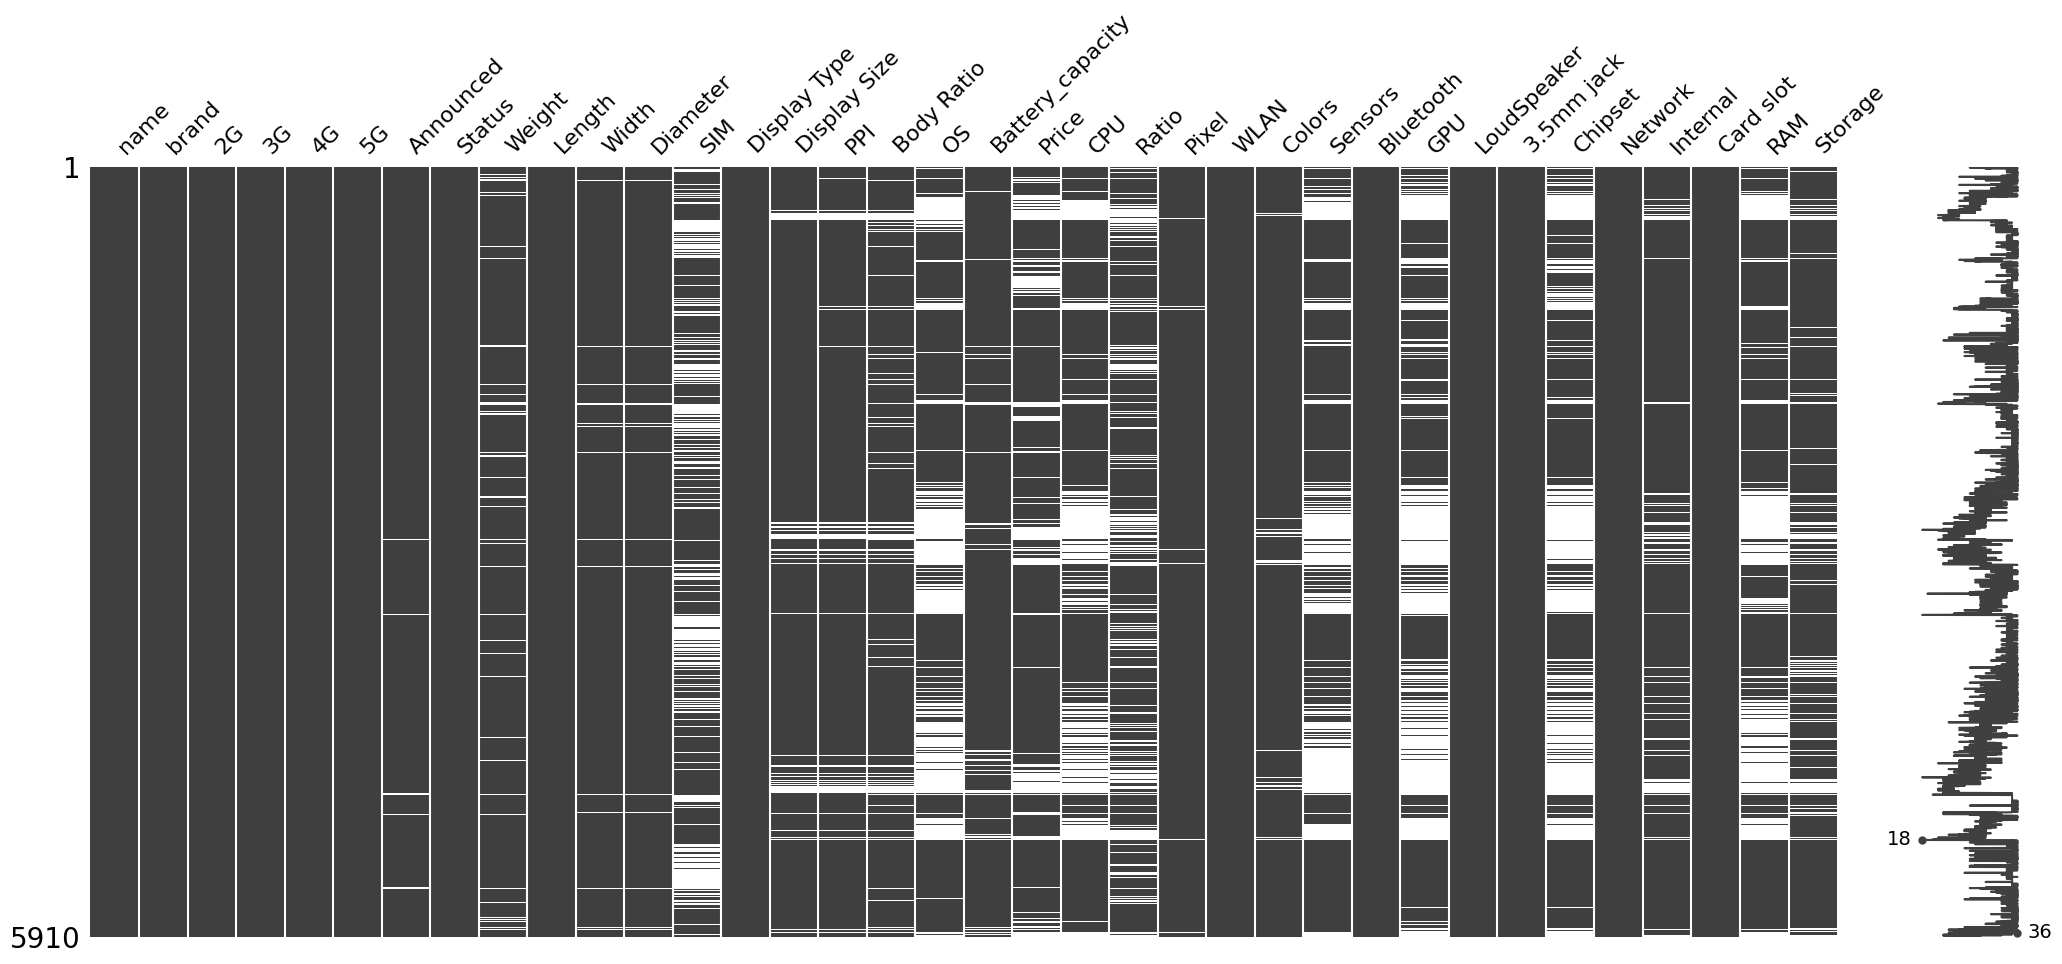

In [369]:
msno.matrix(df)

In [370]:
null_values = df['Price'].isnull().sum() 

In [371]:
null_values # These records don't have price, we can use them for testing phase later; maybe?!

1195

In [372]:
df = df.dropna(subset=['Price'])   # Removed rows with Null value as their price 
df.shape

(4715, 36)

In [373]:
# pd.set_option('display.max_rows', None)        # Show all rows  
# pd.set_option('display.max_columns', None)     # Show all columns  

In [374]:
# pd.set_option('display.max_rows', 10)        # Default Settings  
# pd.set_option('display.max_columns', 20)      

In [375]:
def extract_price_in_eur(price_str):  
    usd_pattern = re.compile(r'\$\s*(\d+(\.\d+)?)') 
    gbp_pattern = re.compile(r'£\s*(\d+(\.\d+)?)') 
    inr_pattern = re.compile(r'₹\s*(\d+(\.\d+)?)') 
    
    try:
        # Handle cases with '€' in it initial state
        if '€' in price_str:   
            euro_price = 0
            parts = price_str.split('€')[1]
            parts1 = parts.split(' ')[0]
            price_float = float(parts1.replace(',', '')) 
            return price_float 
        
        # Handle cases with 'About' in it 
        elif 'About' in price_str:  
            if 'BTC' in price_str:
                parts3 = price_str.split(' ')[2]
                parts4 = parts3.split('/')[0]
                return float(parts4) * 94044.08

            else:
                return float(price_str.split(' ')[1])

        # Handle cases with converting $ to €
        elif usd_pattern.search(price_str):  
            return float(usd_pattern.search(price_str).group(1)) * 0.97

        # Handle cases with converting £ to €
        elif gbp_pattern.search(price_str):  
            return float(gbp_pattern.search(price_str).group(1)) * 1.18

         # Handle cases with converting ₹ to €
        elif inr_pattern.search(price_str):  
            inr_price = 0
            parts5 = price_str.split('₹')[1]
            parts6 = parts5.split(' ')[0]
            price_float = float(parts6.replace(',', '')) 
            return price_float * 0.011

    except Exception as e:    
        print(f"An error occurred: {e}")  
        return -1  # Return -1 if no price found or invalid format

In [376]:
df['Price'] = df['Price'].apply(extract_price_in_eur)  

C:\Users\user\AppData\Local\Temp\ipykernel_11896\3150977457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = df['Price'].apply(extract_price_in_eur)


In [377]:
def convert_to_mb(value):
    if pd.isna(value):
        return None
    
    if isinstance(value, str):
        values_mb = []
        for item in value.split(', '):
            match = re.match(r'(\d+)([A-Z]{2})', item)
            if match:
                num, unit = match.groups()
                num = float(num)
                if unit == 'GB':
                    values_mb.append(num * 1024)
                elif unit == 'MB':
                    values_mb.append(num)
                elif unit == 'KB':
                    values_mb.append(num / 1024)
        return ', '.join(map(str, map(int, values_mb))) if values_mb else None
    elif isinstance(value, (int, float)):
        return str(int(value))
    else:
        return None

In [378]:
df['RAM'] = df['RAM'].apply(convert_to_mb)
df['Storage'] = df['Storage'].apply(convert_to_mb)

C:\Users\user\AppData\Local\Temp\ipykernel_11896\502655593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RAM'] = df['RAM'].apply(convert_to_mb)
C:\Users\user\AppData\Local\Temp\ipykernel_11896\502655593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Storage'] = df['Storage'].apply(convert_to_mb)


In [379]:
def extract_year(date_str):
    if re.match(r'^\d{4}$', str(date_str)):
        return int(date_str)
    match = re.search(r'\b\d{4}\b', str(date_str))
    if match:
        return int(match.group())
    return pd.NaT

In [380]:
df['Announced'] = df['Announced'].apply(extract_year)

C:\Users\user\AppData\Local\Temp\ipykernel_11896\3743856404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Announced'] = df['Announced'].apply(extract_year)


In [381]:
df

,name,brand,2G,3G,4G,5G,Announced,Status,Weight,Length,...,Bluetooth,GPU,LoudSpeaker,3.5mm jack,Chipset,Network,Internal,Card slot,RAM,Storage
0,1,alcatel,True,True,True,False,2018,Available,134.0,137.6,...,"4.2, A2DP, LE",PowerVR GE8100,True,True,Mediatek MT6739 (28 nm),GSM / HSPA / LTE,"8GB 1GB RAM, 16GB 1GB RAM",microSDHC (dedicated slot),1024,"16384, 8192"
1,3,alcatel,True,True,True,False,2018,Available,145.0,147.1,...,"4.2, A2DP, LE",PowerVR GE8100,True,True,Mediatek MT6739 (28 nm),GSM / HSPA / LTE,16GB 2GB RAM,microSDXC,2048,16384
2,5,alcatel,True,True,True,False,2018,Available,144.0,152.3,...,"4.2, A2DP, LE",Mali-T860MP2,True,True,Mediatek MT6750 (28 nm),GSM / HSPA / LTE,"16GB 2GB RAM, 32GB 3GB RAM",microSDXC,"2048, 3072","16384, 32768"
3,7,alcatel,True,True,True,False,2018,Available,175.0,162.1,...,"4.0, A2DP, LE",Mali-G71 MP2,True,True,Mediatek MT6763T Helio P23 (16 nm),GSM / HSPA / LTE,32GB 2GB RAM,microSDXC (dedicated slot),2048,32768
5,2001,alcatel,True,False,False,False,2013,discontinued,89.0,112,...,"3.0, A2DP, EDR",NaN,True,True,NaN,GSM,NaN,microSDHC (dedicated slot),None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,Racer II,ZTE,True,True,False,False,2011,discontinued,100.0,104,...,"2.1, A2DP, EDR",NaN,True,True,NaN,GSM / HSPA,256MB 512MB RAM,microSDHC (dedicated slot),512,256
5872,Libra,ZTE,True,True,False,False,2011,discontinued,NaN,-,...,"2.1, A2DP",Adreno 200,True,True,Qualcomm MSM7227 Snapdragon S1,GSM / HSPA,NaN,microSD (dedicated slot),None,None
5874,Blade,ZTE,True,True,False,False,2010,discontinued,110.0,116,...,"2.1, A2DP, EDR",Adreno 200,True,True,Qualcomm MSM7227 Snapdragon S1,GSM / HSPA,"512MB RAM, 512MB","microSDHC (dedicated slot), 2 GB included",512,512
5886,F107,ZTE,True,True,False,False,2010,discontinued,90.0,105.7,...,"2.1, A2DP",NaN,True,False,NaN,GSM / UMTS,35MB,microSDHC (dedicated slot),None,35
